# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Preparing data

In [2]:
train_path = './myArchive/train'
test_path = './myArchive/test'
valid_path = './myArchive/valid'

# Define image size and batch size
img_size = 256  # Adjust these values if your images have a different size
batch_size = 16

# Define ImageDataGenerators for loading and augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255,              # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest' )
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get the class names
class_names = list(train_generator.class_indices.keys())

# Display class names
print("Class names:", class_names)

Found 1946 images belonging to 10 classes.
Found 238 images belonging to 10 classes.
Found 255 images belonging to 10 classes.
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


# Training

In [3]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.train_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(val_f1)

        train_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        train_targ = self.validation_data[1]
        train_f1 = f1_score(train_targ, train_predict, average='macro')
        self.train_f1s.append(train_f1)

        print(f' — val_f1: {val_f1} — train_f1: {train_f1}')
        return

metrics = Metrics()


In [4]:
# Build the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax'),
])

# Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=valid_generator,
                    callbacks=[cp_callback, metrics])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.1105 - loss: 2.8267
Epoch 1: saving model to training_1/cp.weights.h5


TypeError: 'NoneType' object is not subscriptable

# Testing the model

In [ ]:
# Plotting accuracy and F1 score
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(1, 2, 2)
plt.plot(epochs, metrics.train_f1s, label='Training F1 Score')
plt.plot(epochs, metrics.val_f1s, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.6344 - loss: 1.0725
Test accuracy: 0.615686297416687
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
F1 Score:  0.08828016207141727
Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.08      0.08      0.08        26
        CARACAL       0.13      0.15      0.14        26
        CHEETAH       0.00      0.00      0.00        25
CLOUDED LEOPARD       0.16      0.12      0.14        25
         JAGUAR       0.06      0.08      0.07        26
          LIONS       0.00      0.00      0.00        25
         OCELOT       0.15      0.16      0.16        25
           PUMA       0.11      0.12      0.11        26
   SNOW LEOPARD       0.13      0.16      0.15        25
          TIGER       0.06      0.04      0.05        26

       accuracy                           0.09       255
      macro avg       0.09      0.09      0.09       255
   weighted avg       0.09      0.09      0.09       

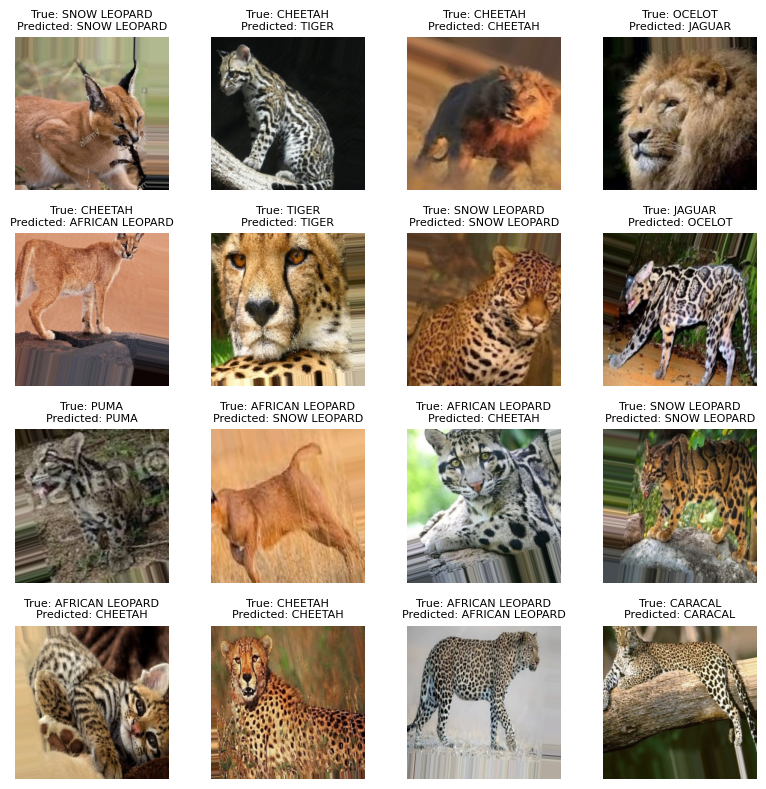

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Generate predictions
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

# Gather true labels
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels[:len(true_labels)], average='weighted')
print('F1 Score: ', f1)

# Classification report
report = classification_report(true_labels, predicted_labels[:len(true_labels)], target_names=class_names)
print('Classification Report:\n', report)

# Make predictions on the test dataset
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = list(test_generator.class_indices.keys())
for i in range(10):
    x_batch, y_batch = train_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))

    # print('true_labels', true_labels)
    # print('predicted_labels', predicted_labels)


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

print('true_class_labels', true_class_labels)
print('predicted_class_labels', predicted_class_labels)

# Plot true labels and predicted labels
plt.figure(figsize=(8, 8))
num_samples_to_display = min(16, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()



# Effnet

## Compile

In [ ]:
# Load EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='elu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_effnet.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_effnet = model_effnet.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 64s 460ms/step - accuracy: 0.0944 - loss: 2.3433 - val_accuracy: 0.1008 - val_loss: 2.3069
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 443ms/step - accuracy: 0.1022 - loss: 2.3233 - val_accuracy: 0.1008 - val_loss: 2.3197
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 438ms/step - accuracy: 0.0923 - loss: 2.3309 - val_accuracy: 0.0966 - val_loss: 2.3223
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 447ms/step - accuracy: 0.0970 - loss: 2.3205 - val_accuracy: 0.1008 - val_loss: 2.3212
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 431ms/step - accuracy: 0.0961 - loss: 2.3284 - val_accuracy: 0.1008 - val_loss: 2.3180
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 431ms/step - accuracy: 0.0924 - loss: 2.3229 - val_accuracy: 0.1008 - val_loss: 2.3216
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 421ms/step - accuracy: 0.0960 - loss: 2.3220 - val_accuracy: 0.0966 - val_loss: 2.3104
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 424ms/step - accuracy: 0.1052 - loss: 2.3153 - val

## Comparison

In [ ]:
# Evaluate the model on the test dataset
test_loss_effnet, test_acc_effnet = model_effnet.evaluate(test_generator)
print('EfficientNetB0 Test accuracy:', test_acc_effnet)
from sklearn.metrics import f1_score, classification_report

# Generate predictions for the test set
predictions_effnet = model_effnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels_effnet = np.argmax(predictions_effnet, axis=1)

# predictions_original = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# predicted_labels_original = np.argmax(predictions_original, axis=1)

# Gather true labels
true_labels = test_generator.classes

# Calculate F1 scores
f1_effnet = f1_score(true_labels, predicted_labels_effnet[:len(true_labels)], average='weighted')
print('EfficientNetB0 F1 Score: ', f1_effnet)

# f1_original = f1_score(true_labels, predicted_labels_original[:len(true_labels)], average='weighted')
# print('Original Model F1 Score: ', f1_original)

# Classification reports
report_effnet = classification_report(true_labels, predicted_labels_effnet[:len(true_labels)], target_names=class_names)
print('EfficientNetB0 Classification Report:\n', report_effnet)

# report_original = classification_report(true_labels, predicted_labels_original[:len(true_labels)], target_names=class_names)
# print('Original Model Classification Report:\n', report_original)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.1055 - loss: 2.3044
EfficientNetB0 Test accuracy: 0.10196078568696976
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step
EfficientNetB0 F1 Score:  0.01886818784453283
EfficientNetB0 Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.00      0.00      0.00        26
        CARACAL       0.00      0.00      0.00        26
        CHEETAH       0.00      0.00      0.00        25
CLOUDED LEOPARD       0.00      0.00      0.00        25
         JAGUAR       0.00      0.00      0.00        26
          LIONS       0.00      0.00      0.00        25
         OCELOT       0.00      0.00      0.00        25
           PUMA       0.00      0.00      0.00        26
   SNOW LEOPARD       0.00      0.00      0.00        25
          TIGER       0.10      1.00      0.19        26

       accuracy                           0.10       255
      macro avg       0.01      0.10      0.02       255
   wei

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif